# ML Analysis

In [38]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [39]:
ML_results = 'ML/krr_metrics.json'

In [40]:
with open(ML_results, "r") as f:
    results = json.load(f)

results_df = pd.DataFrame(results).T
results_df.head()

,ksd,kpd,kp,ks,kexp,max_atomic_forces,max_atomic_forces_label
50,0.226877,0.320765,0.272800,0.109856,0.165427,0.078824,0.008756
100,0.207184,0.297995,0.308276,0.111157,0.179250,0.070046,0.008771
200,0.220738,0.277899,0.278636,0.108389,0.162775,0.071973,0.008745
400,0.204674,0.258653,0.249239,0.093568,0.152214,0.069918,0.008756
800,0.185883,0.255672,0.234940,0.090761,0.140553,0.069331,0.008756


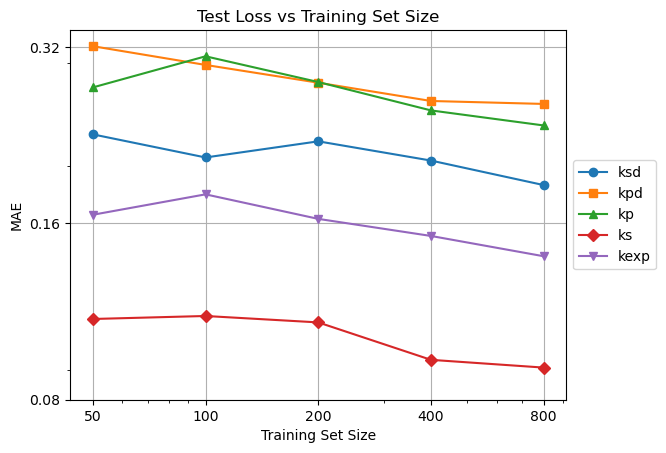

In [41]:
plt.figure()

markers = ['o', 's', '^', 'D', 'v']  # One for each curve
labels = ["ksd", "kpd", "kp", "ks", "kexp"]

# Plot each column with its own marker
for i, col in enumerate(labels):
    plt.plot(
        results_df.index.astype(int),
        results_df[col],
        marker=markers[i],
        label=col,
    )

# Set log scales
plt.xscale("log")
plt.yscale("log")

plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.gca().yaxis.set_minor_formatter(ticker.NullFormatter())

# Custom ticks
xticks = [50, 100, 200, 400, 800]
yticks = [0.08, 0.16, 0.32]
plt.xticks(xticks, labels=[str(x) for x in xticks])
plt.yticks(yticks, labels=[str(y) for y in yticks])

# Labels and title
plt.xlabel("Training Set Size")
plt.ylabel("MAE")
plt.title("Test Loss vs Training Set Size")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.grid()
plt.savefig("ML/test_loss_vs_training_set_size.svg", bbox_inches='tight')

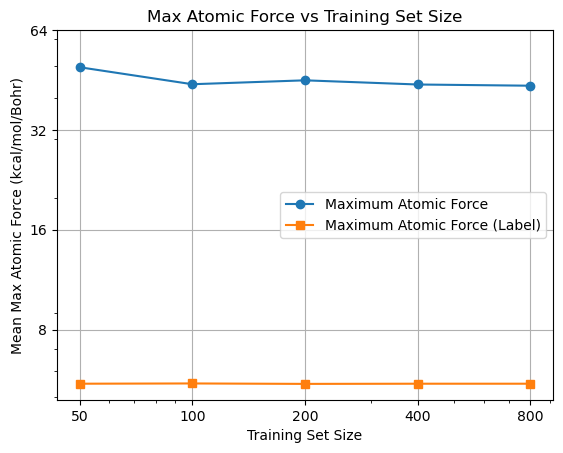

In [42]:
HARTREES_TO_KCAL_MOL = 627.5095

plt.figure()
plt.plot(
    results_df.index.astype(int),
    results_df.loc[:, ["max_atomic_forces"]] * HARTREES_TO_KCAL_MOL,
    marker="o",
)
plt.plot(
    results_df.index.astype(int),
    results_df.loc[:, ["max_atomic_forces_label"]] * HARTREES_TO_KCAL_MOL,
    marker="s",
)
plt.xscale("log")
plt.yscale("log")

xticks = [50, 100, 200, 400, 800]
yticks = [8, 16, 32, 64]
plt.xticks(xticks, labels=[str(x) for x in xticks])
plt.yticks(yticks, labels=[str(y) for y in yticks])

plt.xlabel("Training Set Size")
plt.ylabel("Mean Max Atomic Force (kcal/mol/Bohr)")
plt.title("Max Atomic Force vs Training Set Size")
plt.legend(["Maximum Atomic Force", "Maximum Atomic Force (Label)"])
plt.grid()
plt.savefig(
    "ML/max_atomic_force_vs_training_set_size.svg", bbox_inches="tight"
)